In [1]:
%reload_ext autoreload
%autoreload 2

import os
os.chdir(f"/home/{os.getlogin()}/watttime-python-client-aer-algo")

import optimizer.s3 as s3u
import evaluation.eval_framework as efu

In [2]:
import pandas as pd 
import seaborn as sns 
import numpy as np 
import matplotlib.pyplot as plt

# Import results

In [3]:
s3 = s3u.s3_utils()

regions = ['CAISO_NORTH',
 'SPP_TX',
 'ERCOT_EASTTX',
 'FPL',
 #'SOCO',
 'PJM_CHICAGO',
 'PJM_DC',
 #'NYISO_NYC'
]

dfs = []
for r in regions:
    print(r)
    results_key = f"results/20240726_1k_synth_users_163_days_{r}.csv"
    data = s3.load_csvdataframe(file=results_key)
    data["region"] = r
    dfs.append(data)
    del data

CAISO_NORTH
SPP_TX
ERCOT_EASTTX
FPL
PJM_CHICAGO
PJM_DC


In [25]:
results_data = pd.concat(dfs)

In [26]:
results_data = results_data[~(results_data['region'] == 0)]

## Metrics
- would be interesting to know the forecast error over this period

In [27]:
results_data["ideal_difference"] = results_data["simple_ideal_emissions"] - results_data["simple_actual_emissions"]
results_data["baseline_difference"] = results_data["simple_actual_emissions"] - results_data["baseline_actual_emissions"]
results_data["estimated_difference"] = results_data["simple_actual_emissions"] - results_data["simple_estimated_emissions"]
results_data["largest_possible_difference"] = results_data["simple_ideal_emissions"] - results_data["baseline_actual_emissions"]

results_data["largest_difference_normalized"] = np.divide(results_data["largest_possible_difference"],results_data["power_output_rate"])
results_data["baseline_difference_normalized"] = np.divide(results_data["baseline_difference"],results_data["power_output_rate"])
results_data["optimization_possible"] = results_data["largest_possible_difference"] < 0

## Largest Possible Gain from Simple Optimization
- run the simple optimizer on actual emissions data
- subtract from baseline

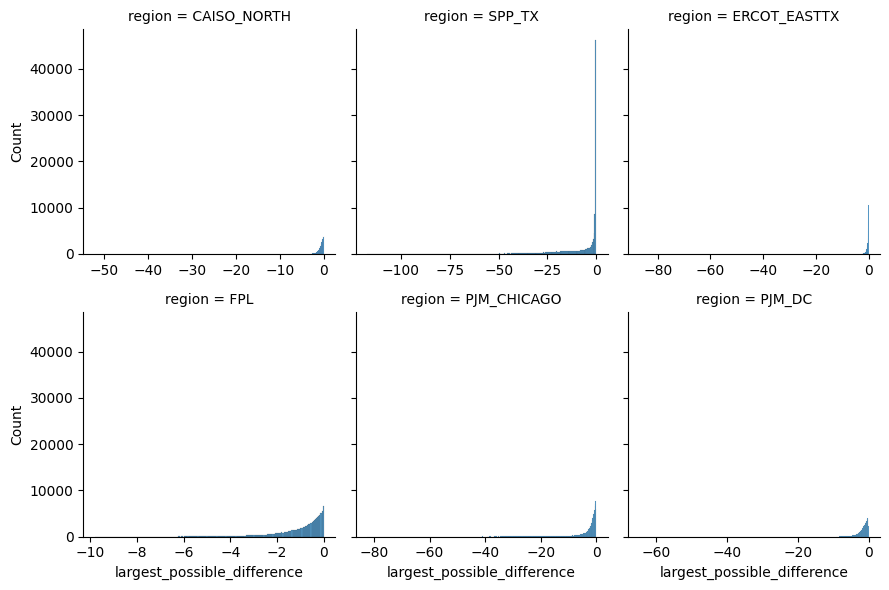

In [9]:
g = sns.FacetGrid(results_data.query('largest_possible_difference != 0'), col="region",sharex=False, col_wrap=3)
g.map(sns.histplot,"largest_possible_difference")

With perfect foresight, using the simple optimizer, what's the most emissions we can avoid in total for all users in each region?

In [114]:
results_data.groupby("region")["largest_possible_difference"].sum()

region
CAISO_NORTH     -85483.504532
ERCOT_EASTTX   -172364.661388
FPL            -115816.834650
PJM_CHICAGO    -498689.538093
PJM_DC         -178019.981538
Name: largest_possible_difference, dtype: float64

<Axes: xlabel='region,optimization_possible'>

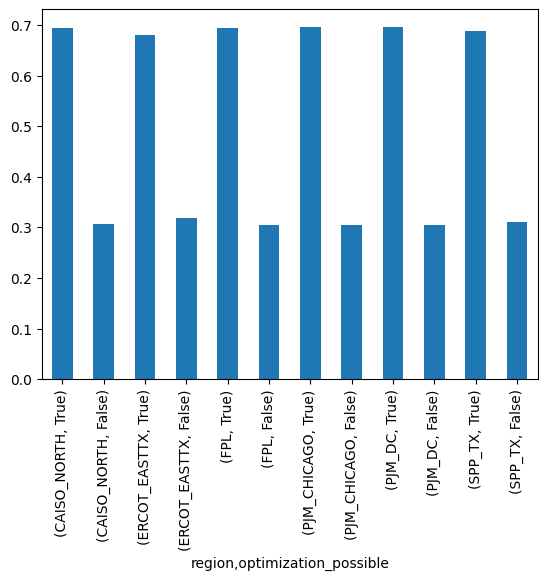

In [10]:
results_data.groupby('region')["optimization_possible"].value_counts(normalize=True).plot(kind='bar')

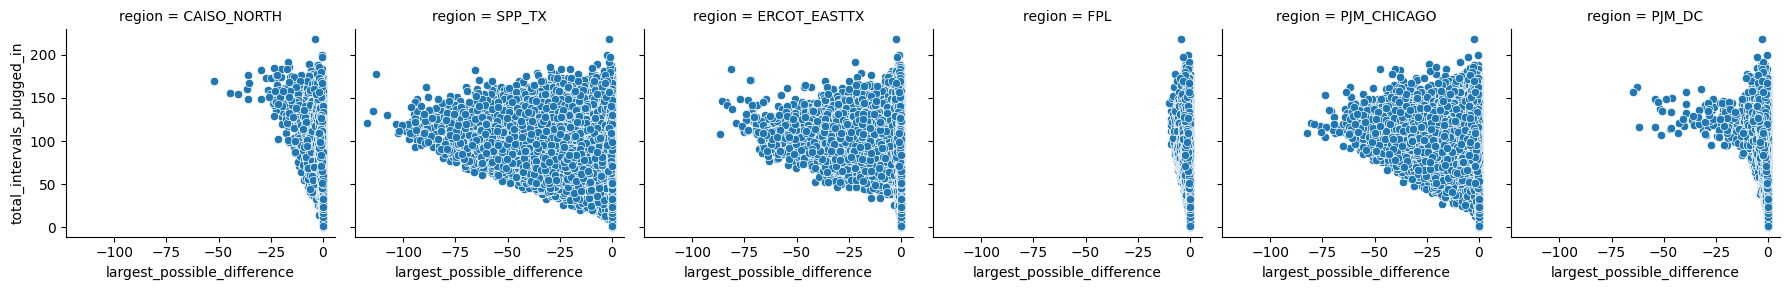

In [11]:
g = sns.FacetGrid(results_data, col="region")
g.map(sns.scatterplot,"largest_possible_difference", "total_intervals_plugged_in")

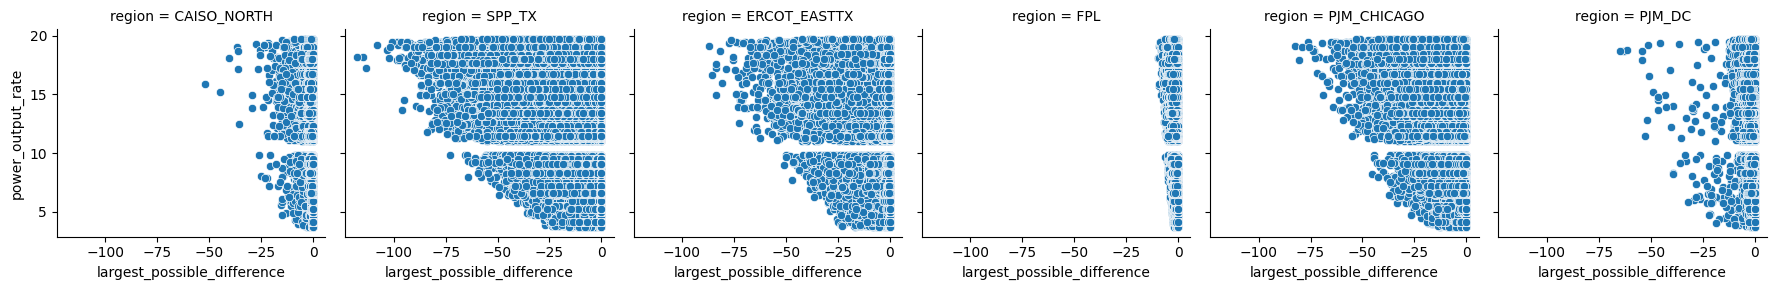

In [12]:
g = sns.FacetGrid(results_data, col="region")
g.map(sns.scatterplot,"largest_possible_difference", "power_output_rate")

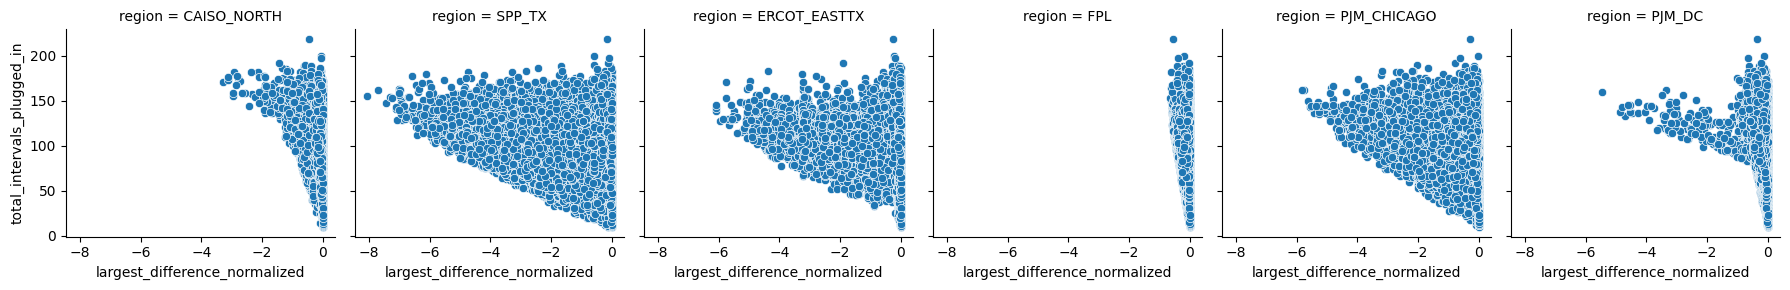

In [13]:
# things get interesting when you're plugged in for over 4 hours. Could reexpress this as odds.
g = sns.FacetGrid(results_data.query('largest_difference_normalized < 0'), col="region")
g.map(sns.scatterplot,"largest_difference_normalized", "total_intervals_plugged_in")

## Optimization Achieved
- baseline difference  = simple optimization "actual" emissions / baseline "actual" emissions
- percent of ideal = baseline difference / largest_possible_differenc

<Axes: xlabel='distinct_dates', ylabel='baseline_difference'>

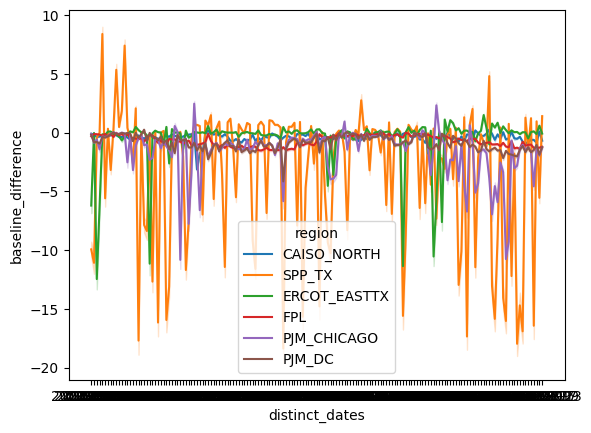

In [14]:
# positive is bad, negative is good

sns.lineplot(results_data, y="baseline_difference",x="distinct_dates", hue="region")

In [28]:
results_data.groupby('region')['baseline_difference'].sum()

region
CAISO_NORTH     -62583.644745
ERCOT_EASTTX    -80083.224835
FPL            -110964.337992
PJM_CHICAGO    -246662.681631
PJM_DC         -142169.031536
SPP_TX         -533483.810860
Name: baseline_difference, dtype: float64

In [43]:
results_data['baseline_difference'].describe()

count    978000.000000
mean         -1.202400
std           4.854601
min        -114.718296
25%          -0.818615
50%          -0.038434
75%           0.000000
max          61.711650
Name: baseline_difference, dtype: float64

In [44]:
(results_data['baseline_difference'] < results_data['largest_possible_difference']).value_counts()

False    976509
True       1491
Name: count, dtype: int64

In [30]:
results_data['largest_possible_difference'].describe()

count    978000.000000
mean         -1.986300
std           6.020663
min        -117.437034
25%          -1.212047
50%          -0.286831
75%           0.000000
max           0.000000
Name: largest_possible_difference, dtype: float64

In [39]:
results_data['percent_ideal_achieved'] = np.divide(
    results_data['baseline_difference'],
    results_data['largest_possible_difference'].replace(0.0,np.nan),
    )

In [41]:
results_data.groupby('region')['percent_ideal_achieved'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
CAISO_NORTH,113103.0,-0.296344,16.104362,-1677.0,0.443965,0.816054,0.941927,1.0
ERCOT_EASTTX,111000.0,-7.315431,64.347369,-5061.0,-1.365028,0.006393,0.501748,1.0
FPL,113240.0,0.410442,9.190694,-1041.0,0.908438,0.988490,0.999955,1.0
PJM_CHICAGO,113457.0,0.408953,4.951012,-1447.0,0.329154,0.706173,0.910952,1.0
PJM_DC,113434.0,0.395231,8.048179,-712.5,0.503557,0.803365,0.932989,1.0
SPP_TX,112212.0,-14.318664,176.211648,-30542.0,-2.666667,0.006863,0.775722,1.0


In [16]:
g = sns.FacetGrid(results_data.query('percent_ideal_achieved <= 0'), col="region", col_wrap = 3)
g.map(sns.histplot,"percent_ideal_achieved")

Error in callback <function flush_figures at 0x7f0f5dfc3b80> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

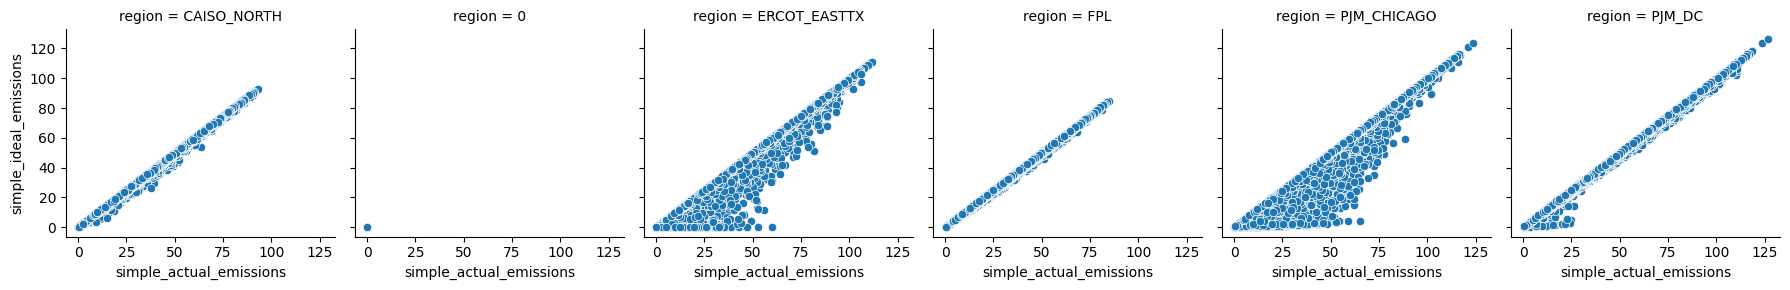

In [126]:
g = sns.FacetGrid(results_data, col="region", col_wrap = 3)
g.map(sns.scatterplot,"simple_actual_emissions", "simple_ideal_emissions")

In [ ]:
g = sns.FacetGrid(results_data, col="region", col_wrap = 3)
g.map(sns.scatterplot,"simple_actual_emissions", "simple_ideal_emissions")